In [21]:
import numpy as np
import os
import PIL
import PIL.Image
import pathlib
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import seaborn as sns
import sklearn.metrics as sk_metrics
from tensorflow.keras import layers

import tensorflow.keras.preprocessing as image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint


import time
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
print(tf.__version__)


2.4.1


## Téléchargement de données
On utilisera une base de données contenant plusieurs images de fleurs de 5 catégories. On Télécharge et extraire un fichier zip contenant les images à partir de ce lien ** "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"**
, ou soit j'utilise ce lien ** "http://localhost:8888/tree/Desktop/autoformation/Transfer_learning/flower_photos"** depuis mon ordinateur parceque j'ai déja téléchargé le dossier **flowers_photos**


In [3]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', # nom du fichier
                                   untar=True) # décompresser le dossier
data_dir = pathlib.Path(data_dir)

## Télécharger le jeu de données
Le jeu de données Flowers_photos contient 5 sous-répertoires, un par classe:
flowers_photos/daisy/dandelion/roses/sunflowers/tulips/

Chaque répertoire contient des images de ce type de fleur. Voici quelques roses:



In [4]:
Nbre_images = len(list(data_dir.glob('*/*.jpg')))
print(Nbre_images) # On a au total 3670 image de fleurs pour les 5 categories

3670


nombres de roses est= 641


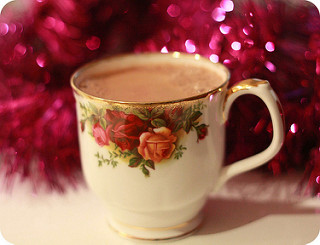

In [5]:
roses = list(data_dir.glob('roses/*'))
print("nombres de roses est=",len(roses))
PIL.Image.open(str(roses[523]))

nombres de tulips est= 799


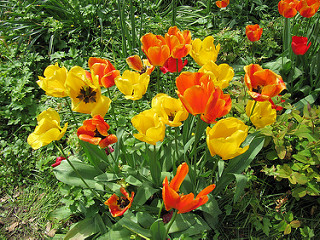

In [6]:
tulips = list(data_dir.glob('tulips/*'))
print("nombres de tulips est=",len(tulips))
PIL.Image.open(str(tulips[120]))

### Charger à l'aide de keras.preprocessing
On crée un **tf.data.Dataset** pour l'apprentissage et la validation à l'aide de **tf.keras.preprocessing.image_dataset_from_directory**
On charge les données avec l'API et on utilise une séparation de validation lors du développement de votre modèle. Nous utiliserons 80% des images pour l'apprentissage et 20% pour la validation

In [7]:
batch_size=32
heigth=180
width=180
channel=3
image_size=(heigth,width)


In [8]:
train_ds=tf.keras.preprocessing.image_dataset_from_directory(
                                data_dir,
                                color_mode='rgb', 
                                batch_size=batch_size,
                                image_size=image_size, 
                                subset="training",
                                 seed=123, validation_split=0.2)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [9]:
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
                                    data_dir,
                                    validation_split=0.2,
                                    subset="validation",
                                    seed=123,
                                    image_size=image_size,
                                    batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [11]:
# On retrouve les nom des classes avec class_names
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### Visualisez les données
Voici les 9 premières images de l'ensemble de données d'entraînement.




32


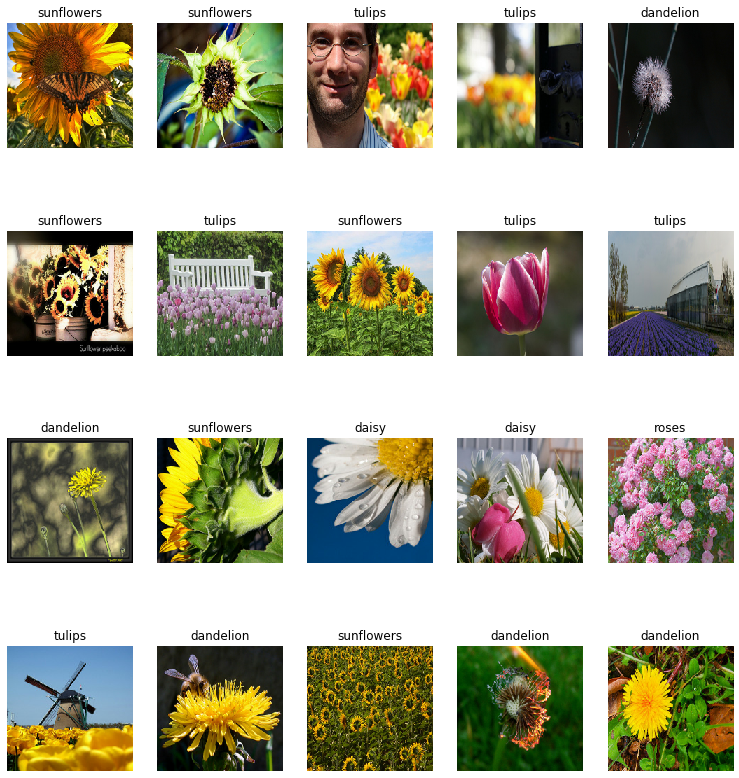

In [12]:
plt.figure(figsize=(13,14))
plt.subplots_adjust(hspace=0.5)
for image,label in train_ds.take(1):
    print(len(label))
    for i in range(20):
        ax=plt.subplot(4,5,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(class_names[label[i]])
        plt.axis("off")

In [13]:
%%time
for imag_train,labes_train in train_ds:
    print("image shape :"+str(imag_train.shape)+", label shape : "+str(label.shape))
    break


image shape :(32, 180, 180, 3), label shape : (32,)
CPU times: user 827 ms, sys: 97.2 ms, total: 924 ms
Wall time: 886 ms


La base de données d'origine ne contient que la training set et validation set. Pour créer un  test set. Pour ce faire, on détermine le nombre de lots de données disponibles dans l'ensemble de validation à l'aide de **tf.data.experimental.cardinality** , puis on déplace 20% d'entre eux vers une nouvelle base qui est test set.

### Augmentation des données
On dispose au totale 3670 images dans notre jeu de données. Ce jeu de données n'est pas assez volumineux, il est recommandé d'introduire artificiellement une diversité d'échantillons en appliquant des transformations aléatoires, mais réalistes, aux images d'entraînement, telles que la rotation et le retournement horizontal. Cela permet d'exposer le modèle à différents aspects des données d'entraînement et de réduire l'overfitting . 

In [15]:
data_augmentation = Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.3),
])

#### Remarque:
Ces couches ne sont actives que pendant l'entraînement, lorsqu'on appele **model.fit** . Ils sont inactifs lorsque le modèle est utilisé en mode inférence dans **model.evaulate** ou model.fit .

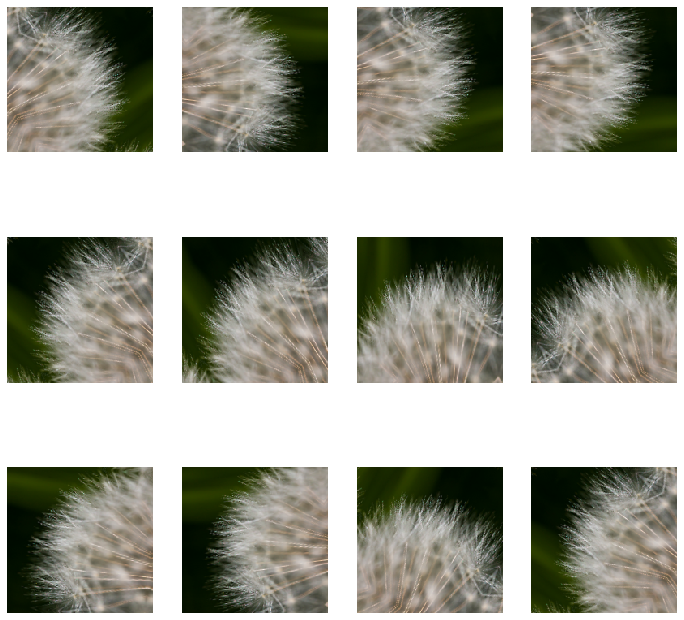

In [16]:
## Exemple
for image, label in train_ds.take(1):
    plt.figure(figsize=(12,12))
    random_image=image[30]
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        augmented_image = data_augmentation(tf.expand_dims(random_image, 0))
        #print(tf.expand_dims(random_image, 0).shape)
        plt.imshow(augmented_image[0]/255)
        plt.axis("off")

## Standardiser les données

Les valeurs de cannaux RVB sont entre [0, 255] . Ce n'est pas idéal pour un réseau neuronal, donc on cherche à réduire vos valeurs d'entrée. Ici, on normalisera les valeurs pour qu'elles soient dans [0, 1] en utilisant une couche de redimensionnement. Si on souhaite mettre à l'échelle les valeurs de pixel à [-1,1] on remplace par Rescaling(1./127.5, offset=-1)


In [18]:

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

Il existe deux manières d'utiliser cette couche. Vous pouvez l'appliquer à l'ensemble de données en appelant la fonction **map**

In [20]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print("min ="+str(np.min(first_image))+", max="+str( np.max(first_image)))

min =0.009804222, max=1.0


### Configurer la base de données pour une meilleur performance
Les GPU et les TPU peuvent réduire considérablement le temps nécessaire pour exécuter une seule étape d'entraînement. Pour atteindre des performances optimales, il faut un pipeline d'entrée efficace qui fournit des données pour l'étape suivante avant la fin de l'étape en cours. L'API tf.data permet de créer des pipelines d'entrée flexibles et efficaces.

La prélecture chevauche le prétraitement et l'exécution du modèle d'une étape d'apprentissage. Pendant que le modèle exécute l'étape d'apprentissage **s** , le pipeline d'entrée lit les données pour l'étape **s+1** . Cela réduit le temps de pas au maximum de formation et le temps nécessaire pour extraire les données.

On utilise la prélecture **tf.data.AUTOTUNE** pour charger des images à partir du disque sans que les E / S deviennent bloquantes. 

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_ds = valid_ds.prefetch(buffer_size=AUTOTUNE)


In [39]:
print(tf.data.experimental.cardinality(train_ds).numpy())


92


## Construction du modèle

In [35]:
num_classes = 5

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.4),

  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.4),

  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.4),
  layers.Dense(num_classes,activation='softmax')
])

In [36]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [37]:
%%time
# sauvegarder les paramètres pendant l'entrainement
#checkpoint_path = "training "
#checkpoint_dir = os.path.dirname(checkpoint_path)

# Création d'un callback qui recharge les paramètres du modèle
#callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 #save_weights_only=True,
                                                 #verbose=0)
history = model.fit(train_ds,epochs=20,validation_data=validation_ds)

Epoch 1/10
92/92 [==============================] - 123s 1s/step - loss: 1.5758 - accuracy: 0.2980 - val_loss: 1.2162 - val_accuracy: 0.4714
Epoch 2/10
92/92 [==============================] - 126s 1s/step - loss: 1.2036 - accuracy: 0.4955 - val_loss: 1.1460 - val_accuracy: 0.5490
Epoch 3/10
92/92 [==============================] - 130s 1s/step - loss: 1.1225 - accuracy: 0.5399 - val_loss: 1.0592 - val_accuracy: 0.5763
Epoch 4/10
92/92 [==============================] - 129s 1s/step - loss: 1.0147 - accuracy: 0.5894 - val_loss: 0.9474 - val_accuracy: 0.6253
Epoch 5/10
92/92 [==============================] - 133s 1s/step - loss: 0.8791 - accuracy: 0.6571 - val_loss: 0.8910 - val_accuracy: 0.6294
Epoch 6/10
92/92 [==============================] - 186s 2s/step - loss: 0.7765 - accuracy: 0.6993 - val_loss: 0.8465 - val_accuracy: 0.6662
Epoch 7/10
92/92 [==============================] - 129s 1s/step - loss: 0.6983 - accuracy: 0.7314 - val_loss: 0.8332 - val_accuracy: 0.6703
Epoch 8/10
92

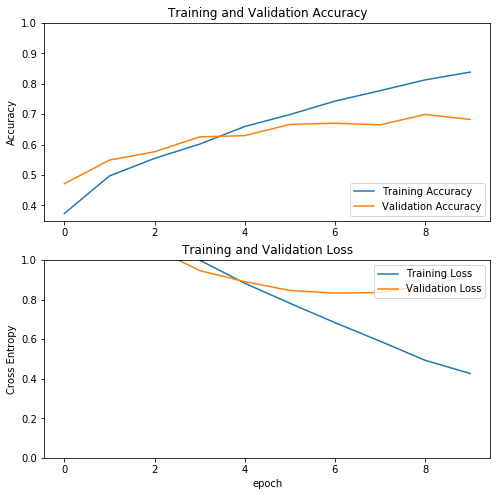

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']

val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()